In [31]:
from scipy import io

In [32]:
mat_file = io.loadmat('C:\\Users\\chaey\\OneDrive - PYLONEER\\999_AI\\P1\\ProjectOne\\simple_lidar_2d\\horizental_lidar.mat')
for data in mat_file.items():
    print(data)

('__header__', b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Wed Nov 16 10:39:16 2016')
('__version__', '1.0')
('__globals__', [])
('timestamps', array([[1.40507630e+18],
       [1.40507630e+18],
       [1.40507630e+18],
       ...,
       [1.40507645e+18],
       [1.40507645e+18],
       [1.40507645e+18]]))
('ranges', array([[ 8.61299992,  8.60299969,  8.60700035, ..., 13.79800034,
        13.81400013, 13.81599998],
       [ 8.60200024,  8.59500027,  8.60999966, ..., 13.82299995,
        13.81200027, 13.81200027],
       [ 8.59899998,  8.59200001,  8.59500027, ..., 13.82400036,
        13.81799984, 13.82800007],
       ...,
       [ 2.9690001 ,  2.93799996,  2.9920001 , ...,  3.2019999 ,
         3.1960001 ,  3.21300006],
       [ 2.99799991,  2.90499997,  2.89299989, ...,  3.22000003,
         3.22799993,  3.25500011],
       [ 2.91400003,  2.87599993,  2.88800001, ...,  3.23399997,
         3.25900006,  3.2809999 ]]))
('intensities', array([[2290, 2293, 2261, ..., 1367, 1360,

In [33]:
import numpy as np
from sklearn.neighbors import NearestNeighbors

"""
ICP Reference : https://github.com/ClayFlannigan/icp/blob/master/icp.py
"""

def best_fit_transform(A, B):
    '''
    Calculates the least-squares best-fit transform that maps corresponding points A to B in m spatial dimensions
    Input:
      A: Nxm numpy array of corresponding points
      B: Nxm numpy array of corresponding points
    Returns:
      T: (m+1)x(m+1) homogeneous transformation matrix that maps A on to B
      R: mxm rotation matrix
      t: mx1 translation vector
    '''

    # get number of dimensions
    m = A.shape[1]

    # translate points to their centroids
    centroid_A = np.mean(A, axis=0)
    centroid_B = np.mean(B, axis=0)
    AA = A - centroid_A
    BB = B - centroid_B

    # rotation matrix
    H = np.dot(AA.T, BB)
    U, S, Vt = np.linalg.svd(H)
    R = np.dot(Vt.T, U.T)

    # translation
    t = centroid_B.T - np.dot(R,centroid_A.T)

    # homogeneous transformation
    T = np.identity(m+1)
    T[:m, :m] = R
    T[:m, m] = t

    return T, R, t

def nearest_neighbor(src, dst):
    '''
    Find the nearest (Euclidean) neighbor in dst for each point in src
    Input:
        src: Nxm array of points
        dst: Nxm array of points
    Output:
        distances: Euclidean distances of the nearest neighbor
        indices: dst indices of the nearest neighbor
    '''

    neigh = NearestNeighbors(n_neighbors=1)
    neigh.fit(dst)
    distances, indices = neigh.kneighbors(src, return_distance=True)
    return distances.ravel(), indices.ravel()

def icp(A, B, init_pose=None, max_iterations=100, tolerance=0.001):
    '''
    The Iterative Closest Point method: finds best-fit transform that maps points A on to points B
    Input:
        A: Nxm numpy array of source mD points
        B: Nxm numpy array of destination mD point
        init_pose: (m+1)x(m+1) homogeneous transformation
        max_iterations: exit algorithm after max_iterations
        tolerance: convergence criteria
    Output:
        T: final homogeneous transformation that maps A on to B
        distances: Euclidean distances (errors) of the nearest neighbor
        i: number of iterations to converge
    '''

    # get number of dimensions
    m = A.shape[1]

    # make points homogeneous, copy them to maintain the originals
    src = np.ones((m+1,A.shape[0]))
    dst = np.ones((m+1,B.shape[0]))
    src[:m,:] = np.copy(A.T[:m, :])
    dst[:m,:] = np.copy(B.T[:m, :])

    # apply the initial pose estimation
    if init_pose is not None:
        src = np.dot(init_pose, src)

    prev_error = 0

    for i in range(max_iterations):
        # find the nearest neighbors between the current source and destination points
        distances, indices = nearest_neighbor(src[:m,:].T, dst[:m,:].T)

        # compute the transformation between the current source and nearest destination points
        T,_,_ = best_fit_transform(src[:m,:].T, dst[:m,indices].T)   # indices = dst의 index [1,3,0,2]
                                                                     #           src의 index [0,1,2,3]

        # update the current source
        src = np.dot(T, src)

        # check error
        mean_error = np.mean(distances)

        if np.abs(prev_error - mean_error) < tolerance:
            break
        prev_error = mean_error

    # calculate final transformation
    T,_,_ = best_fit_transform(A[:, :m], src[:m,:].T)

    return T

In [34]:

import numpy as np
from scipy import io
from math import pi, cos, sin

import csv

def pol2cart(angles, ranges):
    cart = []
    xs = ranges * np.cos(angles)
    ys = ranges * np.sin(angles)
    cart = np.array([xs,ys]).T    #N*2 array

    return cart


def ReadData(data):
    if data ==0:
        #Deutsches Museum Data
        name = "Deutsches_Museum"
        lidar = Lidar(-2.351831,2.351831,1079)
        mat_file = io.loadmat('./horizental_lidar.mat')
        lidar_data = np.array(mat_file['ranges'])

    elif data ==1:
        #SNU Library Data
        name = "SNU_Library"
        lidar = Lidar(-pi,pi,898)
        f = open("data/laser.txt", 'r')
        lines = f.readlines()
        ranges = []
        for line in lines:
            ranges += list(map(float, line.split()))
        lidar_data = np.array(ranges).reshape(-1,898)
        f.close()
    elif data ==2:
        name = "full_Library"
        lidar = Lidar(-pi,pi,721)
        f = open("data/lidar_2.txt",'r')
        lines = f.readlines()
        ranges = []
        for line in lines:
            if '[' in line:
                line = line[1:]
            elif ']' in line:
                line = line[:-2]
            ranges += list(map(float, line.split()))
        lidar_data = np.array(ranges).reshape(-1,721)
    else:
        #Simulation Data
        name = "Simulation"
        lidar = Lidar(-pi,pi,360)
        f = open("data/range.csv", 'r')
        rdr = csv.reader(f)
        ranges = []
        for line in rdr:
            ranges += list(map(float,line))
        lidar_data = np.array(ranges).reshape(-1,360)
        f.close()
    return lidar, lidar_data, name

class Lidar():
    def __init__(self, angle_min, angle_max, npoints, range_min = 0.23, range_max = 60):
        self.angle_min = angle_min
        self.angle_max = angle_max
        self.angle_increment = (angle_max-angle_min)/npoints
        self.npoints = npoints
        self.range_min = range_min
        self.range_max = range_max
        self.scan_time = 0.025
        self.time_increment = 1.736112e-05
        self.angles = np.arange(self.angle_min, self.angle_max, self.angle_increment)

    def ReadAScan(self,lidar_data, scan_id, usableRange):
        ranges = lidar_data[scan_id]

        #Remove points whose range is not so trustworthy
        maxRange = min(self.range_max, usableRange)
        angle = self.angles[(self.range_min<ranges) & (ranges<maxRange)]
        range = ranges[(self.range_min<ranges) & (ranges<maxRange)]

        #Convert from polar coordinates to cartesian coordinates
        scan = pol2cart(angle,range)

        return scan


def v2t(pose):
    # from vector to transform
    tx = pose[0]
    ty = pose[1]
    theta = pose[2]
    transform = np.array([[np.cos(theta), -np.sin(theta), tx],
                          [np.sin(theta), np.cos(theta), ty],
                          [0, 0, 1]])

    return transform

def t2v(T):
    # from transform to vector
    v = np.zeros((3,))
    v[:2] = T[:2,2]
    v[2] = np.arctan2(T[1,0], T[0,0])
    return v

def localToGlobal(pose, scan):
    scanT = np.copy(scan.T)
    frame = np.ones((3, scan.shape[0]))
    frame[0, :] = scanT[0, :]
    frame[1, :] = scanT[1, :]

    transform = v2t(pose)

    scan_global = np.dot(transform, frame)[:2, :] # (2, N) matrix
    scan_global = scan_global.T # (N, 2) matrix

    return scan_global






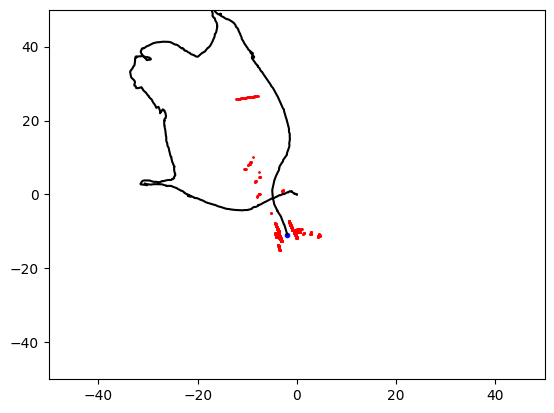

In [35]:
import matplotlib.pyplot as plt
import imageio
import os

if __name__ == "__main__":
    lidar, lidar_data, name = ReadData(0)
    images = []

    start = 0
    end = 5000
    gap = 5

    pose = [0, 0, 0]

    traj = []

    for i in range(start, end, gap):

        scan_before_local = lidar.ReadAScan(lidar_data, i, 60) # (N , 2)
        scan_current_local = lidar.ReadAScan(lidar_data, i+gap, 60) # (N' ,2)

        scan_before_global = localToGlobal(pose, scan_before_local)
        scan_current_global = localToGlobal(pose, scan_current_local)

        plt.clf()
        plt.xlim([-50, 50])
        plt.ylim([-50, 50])

        plt.plot(pose[0], pose[1], 'o', color='blue', markersize=3)
        traj.append(pose)

        traj_array = np.array(traj)
        plt.plot(traj_array[:, 0], traj_array[:, 1], color='black')

        T = icp(scan_current_global, scan_before_global)

        pose_T = v2t(pose)
        pose = t2v(np.copy(np.dot(T, pose_T)))

        frame = np.ones((3, scan_current_global.shape[0]))
        frame[:2, :] = scan_current_global.T
        result = (T @ frame)[:2, :].T

        plt.plot(result[:, 0], result[:, 1], 'o', markersize=1, color='red')
        plt.savefig('.\\result\\{}.png'.format(i), dpi=300)


In [ ]:
for i in range(start, end, gap):
    # 이미지 파일로 저장
    image_path = os.path.join('.\\result\\', '{}.png'.format(i))
    plt.savefig(image_path, dpi=300)
    images.append(imageio.imread(image_path))

In [ ]:
images